## Red meat & colorectal cancer

Analysis of Relative Risks on colorectal cancer in association with red meat consumption. And also possible confounders and selection bias. Based on aggregated data from (NIH)-AARP
- Example of *confounding*: bias due to fruit intake
- Example of *selection bias*: differential loss to follow up due to coincidence of more than one cancer

### References:
- Cross AJ et al. (2007) A prospective study of red and processed meat intake in relation to cancer risk. PLoS Med
4(12): e325. doi:10.1371/journal


In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(65)


N = 294724+199312
def plot_chart2(my_y, n=np.array([N/5,N/5,N/5,N/5,N/5]), title='', truncate=False, grid=True, kind='red meat'):
    p = my_y/n
    myerr=1.96*np.sqrt(p*(1-p)/n)
  
    plt.errorbar(y=p,x=range(len(myerr)),yerr=[myerr,myerr], uplims=True, lolims=True)
    if not truncate:
        plt.ylim(0,1.3*(max(p)))
    plt.title('estimated proportion of cases per quintile of {} intake (CI 95% {})'.format(kind,title))
    if grid:
        plt.grid()

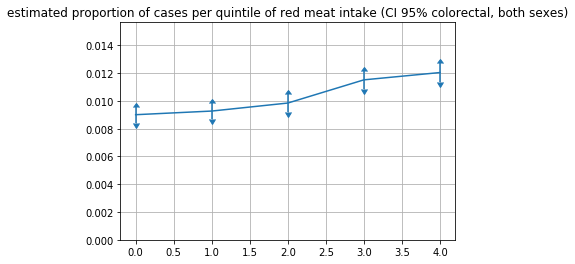

In [2]:
colorectal_cases_men=[472, 570, 674, 820, 935]
colorectal_cases_women=[418, 346, 299, 318, 255]
my_y = np.array(colorectal_cases_men)+np.array(colorectal_cases_women)
plot_chart2(my_y, title='colorectal, both sexes', grid=True)

In [3]:
def ratio_q5_to_q1(N,my_n):
    n=(N/5)*np.array([1,1,1,1,1])
    p = my_y/n
    myerr=1.96*np.sqrt(p*(1-p)/n)
    max_q0=p[0]+myerr[0]
    min_q5=p[4]-myerr[4]
    return(min_q5/max_q0)

relative_risk0 = ratio_q5_to_q1(N,my_y)
print("Minimum relative risk Q5 vs Q1 (CI 95%): {:.4}".format(relative_risk0))

Minimum relative risk Q5 vs Q1 (CI 95%): 1.184


Increase in Relative Risk due to red meat intake seems significant if we don't adjust on sex. In order to adjust on sex we need to estimate fraction of women and men at each quantile

In [4]:
prostate_cases = np.array([2777, 3117, 3588, 3803, 3950])
breast_cases = np.array([1485, 1351, 1292, 1006, 738])

only_women_cases = np.array(breast_cases)
only_men_cases = np.array(prostate_cases)

import numpy as np
def estimate_men_ratio(only_men_cases,only_women_cases):
    masculine = 1*only_men_cases/max(only_men_cases)
    feminine = only_women_cases/max(only_women_cases)
    pman=masculine/(masculine+feminine)
    return(pman)
    

def plot_ratio_estimates(pman):
    plt.plot(pman)
    plt.ylim([0,1])
    plt.title('Estimate ratio of male')
    plt.grid()
    return

def restimate_men_ratio_to_fit_total_number(pman):
    w_m=np.sum(pman*N/5)/294724
    pman = pman/w_m
    return pman


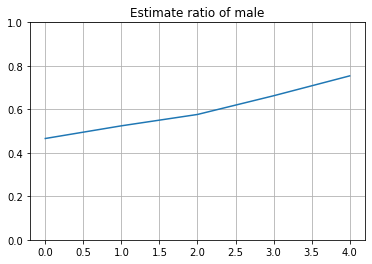

In [5]:
pman=estimate_men_ratio(only_men_cases,only_women_cases)
pman=restimate_men_ratio_to_fit_total_number(pman)
plot_ratio_estimates(pman)
pwoman = 1-pman

Minimum relative risk Q5 vs Q1 (CI 95%): 1.163


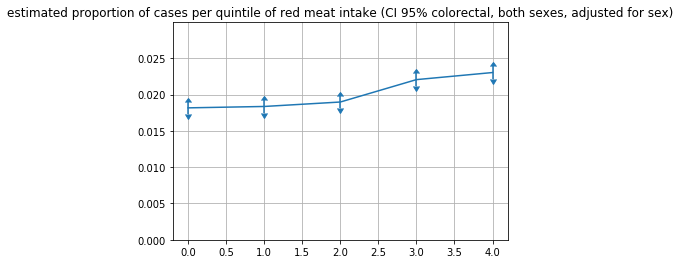

In [6]:
my_y = np.array((colorectal_cases_men/pman)+(colorectal_cases_women/(1-pman)))
plot_chart2(my_y,n=(N/5)*np.array([1,1,1,1,1]),title='colorectal, both sexes, adjusted for sex', grid=True)

relative_risk1 = ratio_q5_to_q1(N,my_y)
print("Minimum relative risk Q5 vs Q1 (CI 95%): {:.4}".format(relative_risk1))

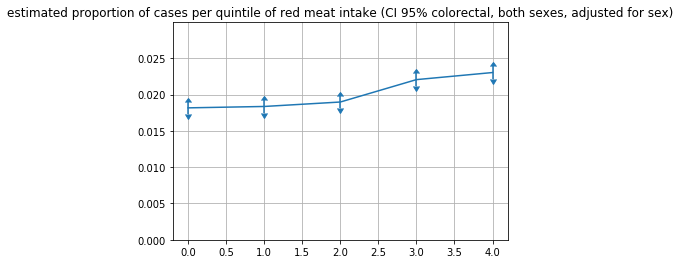

In [7]:
my_y = np.array(colorectal_cases_men/pman+colorectal_cases_women/pwoman)
plot_chart2(my_y, title='colorectal, both sexes, adjusted for sex', grid=True)

Restriction to men:

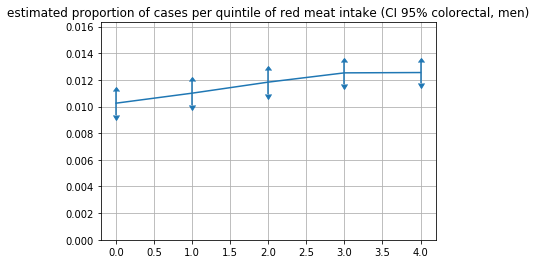

In [8]:
my_y = np.array(colorectal_cases_men)
plot_chart2(my_y,n=(N/5)*pman*np.array([1,1,1,1,1]), title='colorectal, men', grid=True)

Restriction to women:

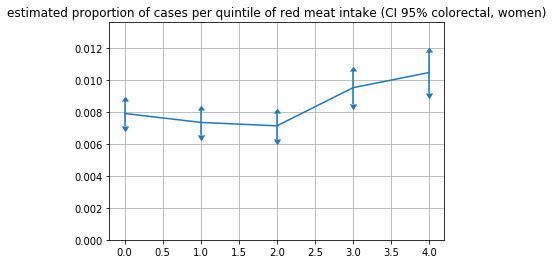

In [9]:
my_y = np.array(colorectal_cases_women)
plot_chart2(my_y,n=(N/5)*(1-pman)*np.array([1,1,1,1,1]), title='colorectal, women', grid=True)

### Analyze relation to fruits consumption

#### Guess distributions for red meat and fruit intake:
- For fruits intake: get my best guess for the relation to meat consumption. And add gaussian noise *N(0,sigma)*

In [10]:
FRUIT_INTAKE_NOISE_SIGMA=0.05
FRUIT_INTAKE_NOISE_SIGMA=0.5

from sklearn.metrics import mean_absolute_error
def estimate_by_grid_search(myformula,mygoal):
    range_i=np.arange(0.1,10.0,0.05)
    range_j=np.arange(0.1,10.0,0.05)
    min_mae=float('inf')
    best_i_j = []
    for i in range_i:
        for j in range_j:
            myguess = eval(myformula)
            mae = mean_absolute_error(myguess,mygoal)
            if (mae < min_mae):
                min_mae = mae
                best_i_j = [i,j]
    return(best_i_j)

In [11]:
myformula2 = 'i/(np.power(np.array([12.0, 24.7, 35.1, 46.8, 67.0]), 1/j))'
mygoal=np.array([2.2,1.7,1.5,1.3,1.1])
(alpha_men,beta_men)=estimate_by_grid_search(myformula2,mygoal)
mygoal=np.array([2.6,2.2,1.9,1.6,1.4])
(alpha_women,beta_women)=estimate_by_grid_search(myformula2,mygoal)

- For meat intake: simulate with lognormal

In [12]:
import numpy as np
#np.random.seed(25)
np.random.seed(35)
Nsample=1000
myqi_sample = np.array([int(Nsample*i/10) for i in range(1,10,2)])
myformula1 = 'np.sort(np.random.lognormal(i,j,Nsample))[myqi_sample]'

mygoal=np.array([7.8,17.6,26.3,36.5,54.7])
(mu_women,sigma_women)=estimate_by_grid_search(myformula1,mygoal)

mygoal=np.array([12.0,24.7,35.1,46.8,67.0])
(mu_men,sigma_men)=estimate_by_grid_search(myformula1,mygoal)

#### Create a fake dataframe
- Masculine and feminine data:

In [13]:
import pandas as pd

Nmen=294724
Nwomen=199312
Ntotal = Nmen+Nwomen
colorectal_cases_men_redmeat=[472,570,674,820,935]
colorectal_cases_women_redmeat=[418,346,299,318,255]
all_cases_men_redmeat = [113+37+48+72+472+38+101+474+188+134+33+202+129+234+71+61+2777, 106+45+98+92+570+56+118+660+251+178+33+227+130+239+67+60+3117, 139+79+90+90+674+65+126+890+282+192+35+279+144+280+94+75+3588, 144+81+103+130+820+68+149+997+310+225+24+280+166+341+79+81+3803, 196+103+130+130+935+89+226+1280+372+267+48+277+188+315+80+92+3950]
all_cases_women_redmeat = [57+10+14+42+418+17+100+506+57+87+55+159+80+157+36+51+1485+333+149+29, 43+18+17+31+346+18+83+566+60+85+56+160+61+110+46+40+1351+274+131+21, 66+16+17+27+299+19+88+467+63+78+29+132+55+100+33+41+1292+236+92+27, 55+18+18+22+318+20+77+512+45+70+38+129+44+79+25+25+1006+204+110+16, 38+9+13+22+255+13+35+417+38+47+21+76+40+77+20+19+738+138+70+24]


def simulate_microdata_intakes(mu_men,sigma_men,Nmen):
    redmeat_intake_men = np.random.lognormal(mu_men,sigma_men,Nmen)
    fruit_intake_men=np.array([alpha_men/np.power(i,1/beta_men)+np.random.normal(0,FRUIT_INTAKE_NOISE_SIGMA) for i in redmeat_intake_men])

    dfm = pd.DataFrame()
    dfm['redmeat']=np.sort(redmeat_intake_men)
    dfm['fruit']=fruit_intake_men[np.argsort(redmeat_intake_men)]
    return (dfm,redmeat_intake_men)

(dfm,redmeat_intake_men) = simulate_microdata_intakes(mu_men,sigma_men,Nmen)
(dfw,redmeat_intake_women) = simulate_microdata_intakes(mu_women,sigma_women,Nwomen)


In [14]:
# To simulate microdata we require the pgender, probability of man or woman at each quintile

def estimate_women_ratio(redmeat_intake_men,redmeat_intake_women,Ntotal):
    redmeat_intake = np.concatenate((redmeat_intake_men,redmeat_intake_women))
    q_th=np.array([int(np.round(Ntotal*i/5)) for i in range(0,6,1)])
    nwomen=[]
    for i in range(len(q_th)-1):
        nwomen.append(np.sum(np.argsort(redmeat_intake)[q_th[i]:q_th[i+1]]-Nmen>0))
    pwoman2=np.array(nwomen)*5/Ntotal
    return pwoman2
    
def simulate_microdata_cases(cases_gender,pgender):   
    my_y = np.array(cases_gender)
    n=(Ntotal/5)*pgender*np.array([1,1,1,1,1])
    p = my_y/n 
    return([np.random.binomial(1,p[i],size=int(np.round(n[i]))) for i in range(len(p))])

In [15]:
pwoman2=estimate_women_ratio(redmeat_intake_men,redmeat_intake_women,Ntotal)

def complete_dataframe_by_gender(dfm,colorectal_cases_men_redmeat,all_cases_men_redmeat,pwoman2, Nmen, gender):
    colorectal_men_microdata = np.concatenate(np.array(simulate_microdata_cases(np.array(colorectal_cases_men_redmeat),(1-pwoman2))))
    assert(len(colorectal_men_microdata)==Nmen)

    all_cases_men_redmeat = np.array(all_cases_men_redmeat)-np.array(colorectal_cases_men_redmeat)
    all_cases_men_microdata= np.concatenate(np.array(simulate_microdata_cases(np.array(all_cases_men_redmeat),(1-pwoman2))))

    dfm = dfm.copy()
    dfm=dfm.iloc[0:len(colorectal_men_microdata)]
    dfm.loc[:,'colorectal_cancer']=colorectal_men_microdata
    
    dfm.loc[:,'all_cancers_except_colorectal']=all_cases_men_microdata
    dfm.loc[:,'gender'] = gender
    return dfm
dfm=complete_dataframe_by_gender(dfm,colorectal_cases_men_redmeat,all_cases_men_redmeat,pwoman2, Nmen, 'M')
dfm.head()

,redmeat,fruit,colorectal_cancer,all_cancers_except_colorectal,gender
0,1.730860,4.305158,0,0,M
1,2.019067,3.290817,0,0,M
2,2.233136,4.843502,0,0,M
3,2.502208,4.283269,0,0,M
4,2.503076,3.929096,0,0,M


In [16]:
dfw=complete_dataframe_by_gender(dfw,colorectal_cases_women_redmeat,all_cases_women_redmeat,1-pwoman2, Nwomen-1, 'W')
dfw.head()

,redmeat,fruit,colorectal_cancer,all_cancers_except_colorectal,gender
0,1.247098,5.191707,0,0,W
1,1.482067,4.713128,0,0,W
2,1.581946,5.072116,0,0,W
3,1.714746,4.580147,1,0,W
4,1.755260,5.297535,0,0,W


- Concatenate masculine and feminine:

In [17]:
df = pd.concat((dfm,dfw))

### Recalculate relative risks based on fake synthetic dataframe
a) sort fake dataframe based on redmeat consumption

In [18]:
df = df.sort_values(by='redmeat').reset_index()
df.sample(10)

,index,redmeat,fruit,colorectal_cancer,all_cancers_except_colorectal,gender
28952,8734,10.716822,2.613162,0,1,M
379871,212148,46.954122,1.352658,0,0,M
170944,91433,22.920181,1.036628,0,0,W
187689,89210,24.284893,1.683813,0,0,M
325796,175641,38.262989,1.402133,0,0,M
36134,24641,11.529320,2.312410,0,0,W
336229,182510,39.702102,0.619774,0,1,M
473334,279075,87.541380,0.666497,0,0,M
141796,63223,20.610456,1.752549,0,0,M
262078,134436,30.993043,1.638479,0,0,M


In [19]:
myidx = np.array([(int(Ntotal*(i-1)/5),int(Ntotal*i/5)) for i in range(1,6)])
colorectal_cases_men_redmeat_syn = [df[(df.gender=='M') & (df.index>=i) & (df.index<j)].colorectal_cancer.sum() for (i,j) in myidx]
colorectal_cases_women_redmeat_syn = [df[(df.gender=='W') & (df.index>=i) & (df.index<j)].colorectal_cancer.sum() for (i,j) in myidx]

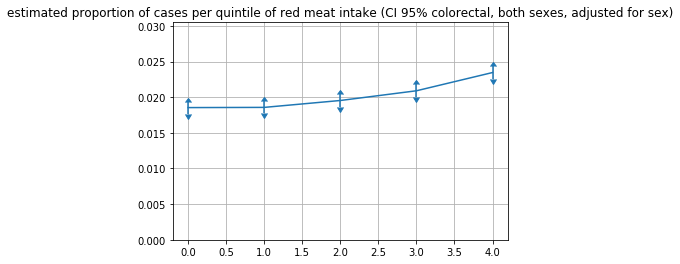

In [20]:
my_y = np.array((colorectal_cases_men_redmeat_syn/(1-pwoman2))+(colorectal_cases_women_redmeat_syn/(pwoman2)))
plot_chart2(my_y,n=(N/5)*np.array([1,1,1,1,1]),kind='red meat',title='colorectal, both sexes, adjusted for sex', grid=True)

In [21]:
relative_risk2 = ratio_q5_to_q1(N,my_y)
print("Minimum relative risk Q5 vs Q1 (CI 95%): {:.4}".format(relative_risk2))
assert(np.round(relative_risk2,2)==np.round(relative_risk1,2))

Minimum relative risk Q5 vs Q1 (CI 95%): 1.162


In order to include the effect of those people loss to follow up due to more than one cancer, we could simulate the following:
- get ratio of colorectal cases of cancer from total cases in women and men
- get (fake) people with more than one cancer
- attribute fraction of hypothetical colorectal cancer according to previous steps

In [22]:
def get_ratio_of_colorectal_vs_total(gender):
    mymask=df['gender']==gender
    return df[mymask].colorectal_cancer.sum()/(df[mymask].all_cancers_except_colorectal.sum()+df[mymask].colorectal_cancer.sum())

ratio_colorectal_in_women=get_ratio_of_colorectal_vs_total('W')
ratio_colorectal_in_men=get_ratio_of_colorectal_vs_total('M')
print("Ratio of colorectal cancer vs total cases of cancer: {:.2} for women, {:.2} for men".format(ratio_colorectal_in_women, ratio_colorectal_in_men))

Ratio of colorectal cancer vs total cases of cancer: 0.11 for women, 0.099 for men


Minimum relative risk Q5 vs Q1 (CI 95%): 1.162


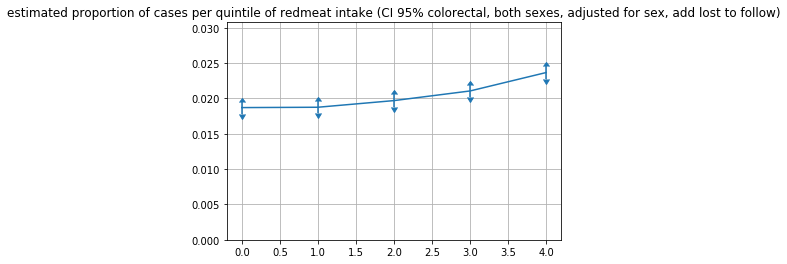

In [23]:
def guess_estimate_loss_to_follow(df):
    loss_to_follow_men_redmeat_syn = np.array([df[(df.gender=='M') & (df.index>=i) & (df.index<j) & (df.colorectal_cancer==1) & (df.all_cancers_except_colorectal==1)].count()[0] for (i,j) in myidx])   
    loss_to_follow_women_redmeat_syn = np.array([df[(df.gender=='W') & (df.index>=i) & (df.index<j) & (df.colorectal_cancer==1) & (df.all_cancers_except_colorectal==1)].count()[0] for (i,j) in myidx])
    loss_to_follow_men = np.round(ratio_colorectal_in_men*loss_to_follow_men_redmeat_syn)
    loss_to_follow_women = np.round(ratio_colorectal_in_women*loss_to_follow_women_redmeat_syn)
    return(loss_to_follow_men, loss_to_follow_women)

loss_to_follow_men_redmeat_syn,loss_to_follow_women_redmeat_syn=guess_estimate_loss_to_follow(df)
my_y = np.array(((colorectal_cases_men_redmeat_syn+loss_to_follow_men_redmeat_syn)/(1-pwoman2))+((colorectal_cases_women_redmeat_syn+loss_to_follow_women_redmeat_syn)/pwoman2))
plot_chart2(my_y, n=(N/5)*np.array([1,1,1,1,1]), kind='redmeat',title='colorectal, both sexes, adjusted for sex, add lost to follow', grid=True)
print("Minimum relative risk Q5 vs Q1 (CI 95%): {:.4}".format(ratio_q5_to_q1(N,my_y)))

b) Reorder dataframe based on fruits intake (reverse):

Minimum relative risk Q5 vs Q1 (CI 95%): 1.001


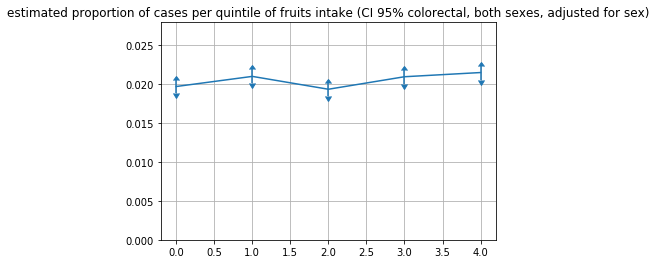

In [24]:
df= df.drop('index',axis=1).sort_values(by='fruit',ascending=False).reset_index()
colorectal_cases_men_fruit_syn = [df[(df.gender=='M') & (df.index>=i) & (df.index<j)].colorectal_cancer.sum() for (i,j) in myidx]
colorectal_cases_women_fruit_syn = [df[(df.gender=='W') & (df.index>=i) & (df.index<j)].colorectal_cancer.sum() for (i,j) in myidx]

my_y = np.array((colorectal_cases_men_fruit_syn/(1-pwoman2))+(colorectal_cases_women_fruit_syn/(pwoman2)))
plot_chart2(my_y,n=(N/5)*np.array([1,1,1,1,1]),kind='fruits',title='colorectal, both sexes, adjusted for sex', grid=True)
print("Minimum relative risk Q5 vs Q1 (CI 95%): {:.4}".format(ratio_q5_to_q1(N,my_y)))

Minimum relative risk Q5 vs Q1 (CI 95%): 1.003


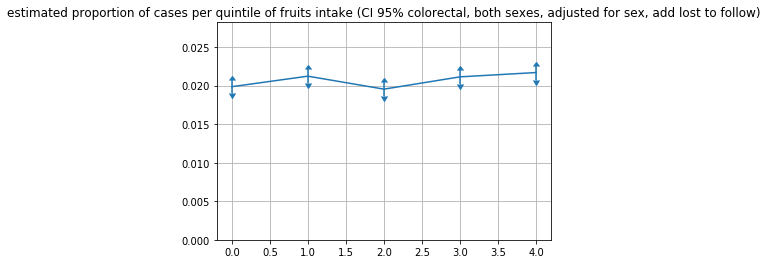

In [25]:
loss_to_follow_men_fruit_syn,loss_to_follow_women_fruit_syn=guess_estimate_loss_to_follow(df)

my_y = np.array(((colorectal_cases_men_fruit_syn+loss_to_follow_men_fruit_syn)/(1-pwoman2))+((colorectal_cases_women_fruit_syn+loss_to_follow_women_fruit_syn)/pwoman2))
plot_chart2(my_y, n=(N/5)*np.array([1,1,1,1,1]), kind='fruits',title='colorectal, both sexes, adjusted for sex, add lost to follow', grid=True)
print("Minimum relative risk Q5 vs Q1 (CI 95%): {:.4}".format(ratio_q5_to_q1(N,my_y)))

### Propensity Score Matching
Steps for this purpose:

1.- **Generate dataframe**: First of all, get a subset with lowest quantile of red meat intake (Q1) as "control" group, and subset with highest quantile (Q5) as "treatment" group

2.- **Estimate Propensity Score**, i.e, the probability of being in the "treatment" group (quantile5) or the "control" group (quantile1), depending on the variables sex and fruit intake. With a logistic regression

3.- **Select paired subpopulation**, i.e, choose elements with balanced propensity scores. After visualizing the histograms of Propensity Score both for "treatment" and "control"

4.- **Estimate Relative Risk**

#### Generate dataframe

In [26]:
df_subset= df.copy()
df_subset.drop('index',axis=1).sort_values(by='redmeat').reset_index()

def is_treatment(i):
    treatment=-1
    if (i<=int(len(df)*1/5-1)):
        treatment = 0
    elif (i>=int(len(df)*(4)/5)):
        treatment=1
    return treatment
    
def is_woman(x):
    woman=0
    if (x=='M'):
        woman=1
    return woman
df_subset['is_treatment']=df_subset['index'].apply(is_treatment)
df_subset['is_woman']=df_subset['gender'].apply(is_woman)

df_subset=df_subset.drop(df_subset[df_subset['is_treatment']==-1].index)
df_subset

,index,redmeat,fruit,colorectal_cancer,all_cancers_except_colorectal,gender,is_treatment,is_woman
0,5,1.755260,5.297535,0,0,W,0,0
1,36,2.458788,5.273457,0,0,W,0,0
2,0,1.247098,5.191707,0,0,W,0,0
3,22,2.163459,5.121216,0,0,W,0,0
4,2,1.581946,5.072116,0,0,W,0,0
...,...,...,...,...,...,...,...,...
494030,427229,59.107535,-1.002666,0,0,M,1,1
494031,482077,102.003635,-1.018446,0,0,M,1,1
494032,417520,55.960689,-1.147928,0,1,M,1,1
494033,493586,207.394589,-1.173829,0,1,M,1,1


#### Estimate Propensity Score

In [27]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score,roc_auc_score
from sklearn.linear_model import LogisticRegression

x = df_subset.loc[:,['fruit','is_woman']].values#.reshape(-1,1)
y = df_subset.loc[:,'is_treatment']#.values.reshape(-1,1)

# We won't do the typical train_test_split in order to compare exactly with the previous models on the training set
# If we would like our model to generalize, we should preferable do train_test_split, or similar technique
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train = x
y_train = y
X_test = x
y_test = y

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)

# The coefficients
print('Coefficients: \n', model.coef_)
# The intercept
print('Intercept: \n', model.intercept_)

print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, y_pred[:,1])))

df_subset['score']=y_pred[:,1]
df_subset

Coefficients: 
 [[-3.86092746  1.17804244]]
Intercept: 
 [5.71567606]
ROC_AUC: 0.94


,index,redmeat,fruit,colorectal_cancer,all_cancers_except_colorectal,gender,is_treatment,is_woman,score
0,5,1.755260,5.297535,0,0,W,0,0,3.976382e-07
1,36,2.458788,5.273457,0,0,W,0,0,4.363766e-07
2,0,1.247098,5.191707,0,0,W,0,0,5.983273e-07
3,22,2.163459,5.121216,0,0,W,0,0,7.854814e-07
4,2,1.581946,5.072116,0,0,W,0,0,9.494375e-07
...,...,...,...,...,...,...,...,...,...
494030,427229,59.107535,-1.002666,0,0,M,1,1,9.999789e-01
494031,482077,102.003635,-1.018446,0,0,M,1,1,9.999801e-01
494032,417520,55.960689,-1.147928,0,1,M,1,1,9.999879e-01
494033,493586,207.394589,-1.173829,0,1,M,1,1,9.999891e-01


Visualizing the distributions of Propensity Scores:

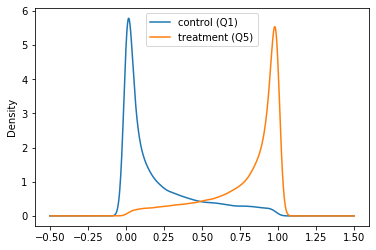

In [28]:
df_subset.loc[(df_subset['is_treatment']==0),'score'].plot(kind='kde', label='control (Q1)')
df_subset.loc[(df_subset['is_treatment']==1),'score'].plot(kind='kde', label='treatment (Q5)')
plt.legend()

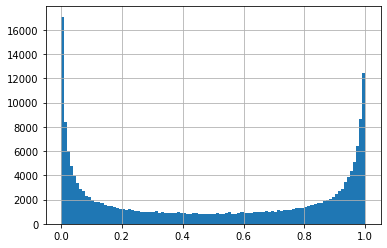

In [29]:
df_subset['score'].hist(bins=100)

#### Selected paired subpopulation

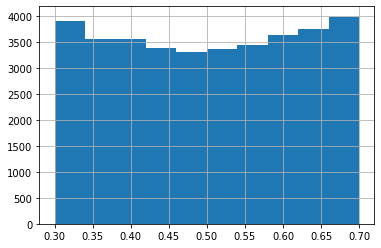

In [30]:
df_matching=df_subset[(df_subset['score']>=0.3) & (df_subset['score']<=0.7)]
df_matching['score'].hist()

#### Estimate Relative Risk

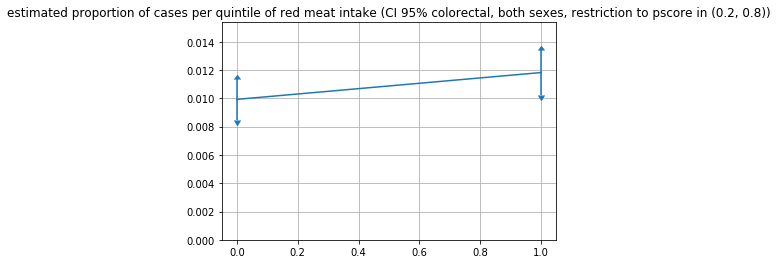

In [31]:
my_y = np.array([df_matching[(df_matching['is_treatment']==0)].colorectal_cancer.sum(),df_matching[(df_matching['is_treatment']==1)].colorectal_cancer.sum()])
plot_chart2(my_y,n=(len(df_matching)/2)*np.array([1,1]),kind='red meat',title='colorectal, both sexes, restriction to pscore in (0.2, 0.8)', grid=True)

In [32]:
def ratio_qlast_to_qfirst(N,my_y):
    size=len(my_y)
    n=(len(df_matching)/size)*np.ones(size)
    p = my_y/n
    myerr=1.96*np.sqrt(p*(1-p)/n)
    max_qfirst=p[0]+myerr[0]
    min_qlast=p[size-1]-myerr[size-1]
    return(min_qlast/max_qfirst)

relative_risk3 = ratio_qlast_to_qfirst(len(df_matching),my_y)
print("Minimum relative risk Q5 vs Q1 (CI 95%): {:.4}".format(relative_risk3))

Minimum relative risk Q5 vs Q1 (CI 95%): 0.9001


Thus, if we restrict (our fake) population to those elements with balanced propensity scores, the Relative Risk of "treatment" (Q5 red meat intake) vs "control" is not significant with 95% confidence